In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS=3
EPOCH=25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "DatasetClean",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3852 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
print(class_names)
print(len(dataset))

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
61


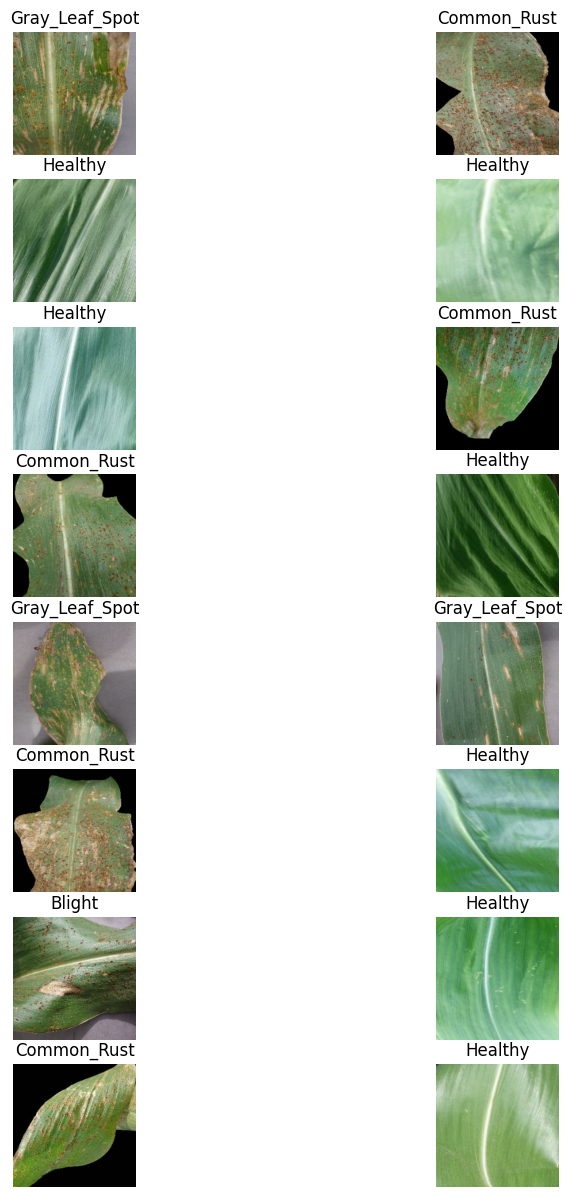

In [5]:
plt.figure(figsize=(10,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(8,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [6]:
# 80% training
train_size = 0.8
print(round(len(dataset)*train_size))

49


In [7]:
train_ds = dataset.take(53)
print(len(train_ds))

53


In [8]:
test_ds = dataset.skip(53)
print(len(test_ds))

8


In [9]:
val_size = 0.1
print(round(len(dataset)*val_size))

6


In [10]:
val_ds = test_ds.take(7)
print(len(val_ds))

7


In [11]:
test_ds = test_ds.skip(7)
print(len(test_ds))

1


In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = round(train_split * ds_size)
    val_size = round(val_split * ds_size)
    test_size = round(test_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

49

In [15]:
len(test_ds)

6

In [16]:
len(val_ds)

6

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmetation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

def identity_block(input_tensor, kernel_size, filters):
    filters1, filters2, filters3 = filters
    
    # First convolutional layer
    x = layers.Conv2D(filters1, (1, 1))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolutional layer
    x = layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Third convolutional layer
    x = layers.Conv2D(filters3, (1, 1))(x)
    x = layers.BatchNormalization()(x)
    
    # Add the identity
    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    return x


# Define the convolutional block
def convolutional_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    
     # First convolutional layer
    x = layers.Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolutional layer
    x = layers.Conv2D(filters2, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Third convolutional layer
    x = layers.Conv2D(filters3, (1, 1))(x)
    x = layers.BatchNormalization()(x)
    
    # Shortcut path
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)
    
    # Add the shortcut and the main path
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x


# Create the ResNet50 model
def resnet50(input_shape, n_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial convolutional layer
    x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    
     # Residual blocks
    x = convolutional_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])

    x = convolutional_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])

    x = convolutional_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])

    x = convolutional_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    
    # Average pooling and final dense layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [21]:
model = resnet50(input_shape, n_classes)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']          

 conv2d_20 (Conv2D)             (None, 28, 28, 512)  66048       ['re_lu_17[0][0]']               
                                                                                                  
 batch_normalization_20 (BatchN  (None, 28, 28, 512)  2048       ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 512)  0           ['batch_normalization_20[0][0]', 
                                                                  're_lu_15[0][0]']               
                                                                                                  
 re_lu_18 (ReLU)                (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21

 batch_normalization_30 (BatchN  (None, 14, 14, 1024  4096       ['conv2d_30[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 add_8 (Add)                    (None, 14, 14, 1024  0           ['batch_normalization_30[0][0]', 
                                )                                 're_lu_24[0][0]']               
                                                                                                  
 re_lu_27 (ReLU)                (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 14, 14, 256)  262400      ['re_lu_27[0][0]']               
          

                                                                                                  
 re_lu_36 (ReLU)                (None, 14, 14, 1024  0           ['add_11[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 14, 14, 256)  262400      ['re_lu_36[0][0]']               
                                                                                                  
 batch_normalization_40 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_37 (ReLU)                (None, 14, 14, 256)  0           ['batch_normalization_40[0][0]'] 
          

 conv2d_50 (Conv2D)             (None, 7, 7, 512)    1049088     ['re_lu_45[0][0]']               
                                                                                                  
 batch_normalization_50 (BatchN  (None, 7, 7, 512)   2048        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_46 (ReLU)                (None, 7, 7, 512)    0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 512)    2359808     ['re_lu_46[0][0]']               
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 512)   2048        ['conv2d_51[0][0]']              
 ormalizat

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/25
49/49 [==============================] - 678s 13s/step - loss: 0.6278 - accuracy: 0.8197 - val_loss: 1229.9532 - val_accuracy: 0.2943
Epoch 2/25
49/49 [==============================] - 640s 13s/step - loss: 0.2535 - accuracy: 0.8959 - val_loss: 2.1447 - val_accuracy: 0.3255
Epoch 3/25
49/49 [==============================] - 620s 13s/step - loss: 0.2030 - accuracy: 0.9225 - val_loss: 2.0366 - val_accuracy: 0.3932
Epoch 4/25
49/49 [==============================] - 619s 13s/step - loss: 0.1769 - accuracy: 0.9274 - val_loss: 1.0385 - val_accuracy: 0.5911
Epoch 5/25
49/49 [==============================] - 622s 13s/step - loss: 0.1376 - accuracy: 0.9507 - val_loss: 0.3005 - val_accuracy: 0.8828
Epoch 6/25
49/49 [==============================] - 624s 13s/step - loss: 0.1273 - accuracy: 0.9497 - val_loss: 6.1925 - val_accuracy: 0.1328
Epoch 7/25
49/49 [==============================] - 640s 13s/step - loss: 0.1305 - accuracy: 0.9494 - val_loss: 1.0006 - val_accuracy: 0.6901
Epo

In [25]:
scores = model.evaluate(test_ds)
print(scores)
print(history.params)

6/6 [==============================] - 17s 3s/step - loss: 1.9290 - accuracy: 0.8281
[1.92900550365448, 0.828125]
{'verbose': 1, 'epochs': 25, 'steps': 49}


In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

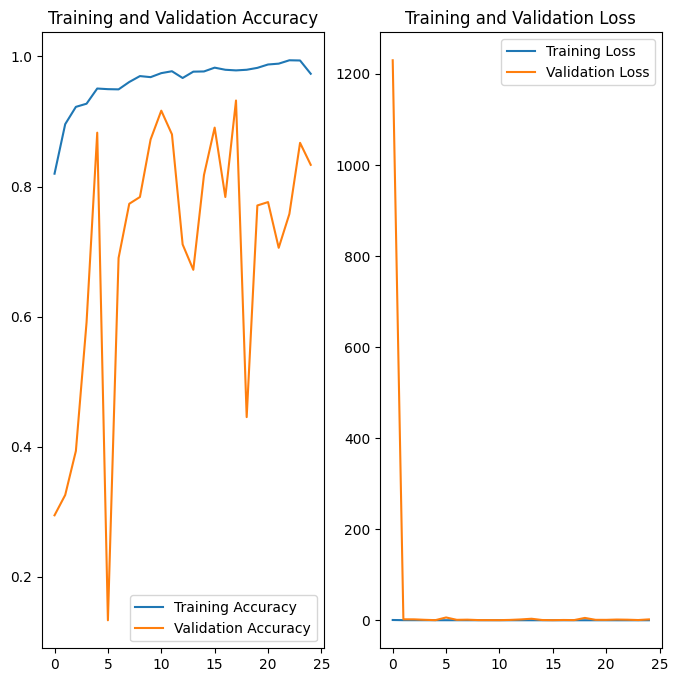

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict First Image
First Image's Actual Label: Blight
2/2 [==============================] - 3s 1s/step
Predicted Label: Blight


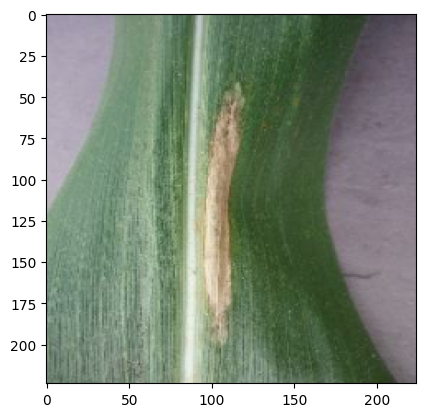

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Predict First Image")
    plt.imshow(first_image)
    print("First Image's Actual Label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 80ms/step


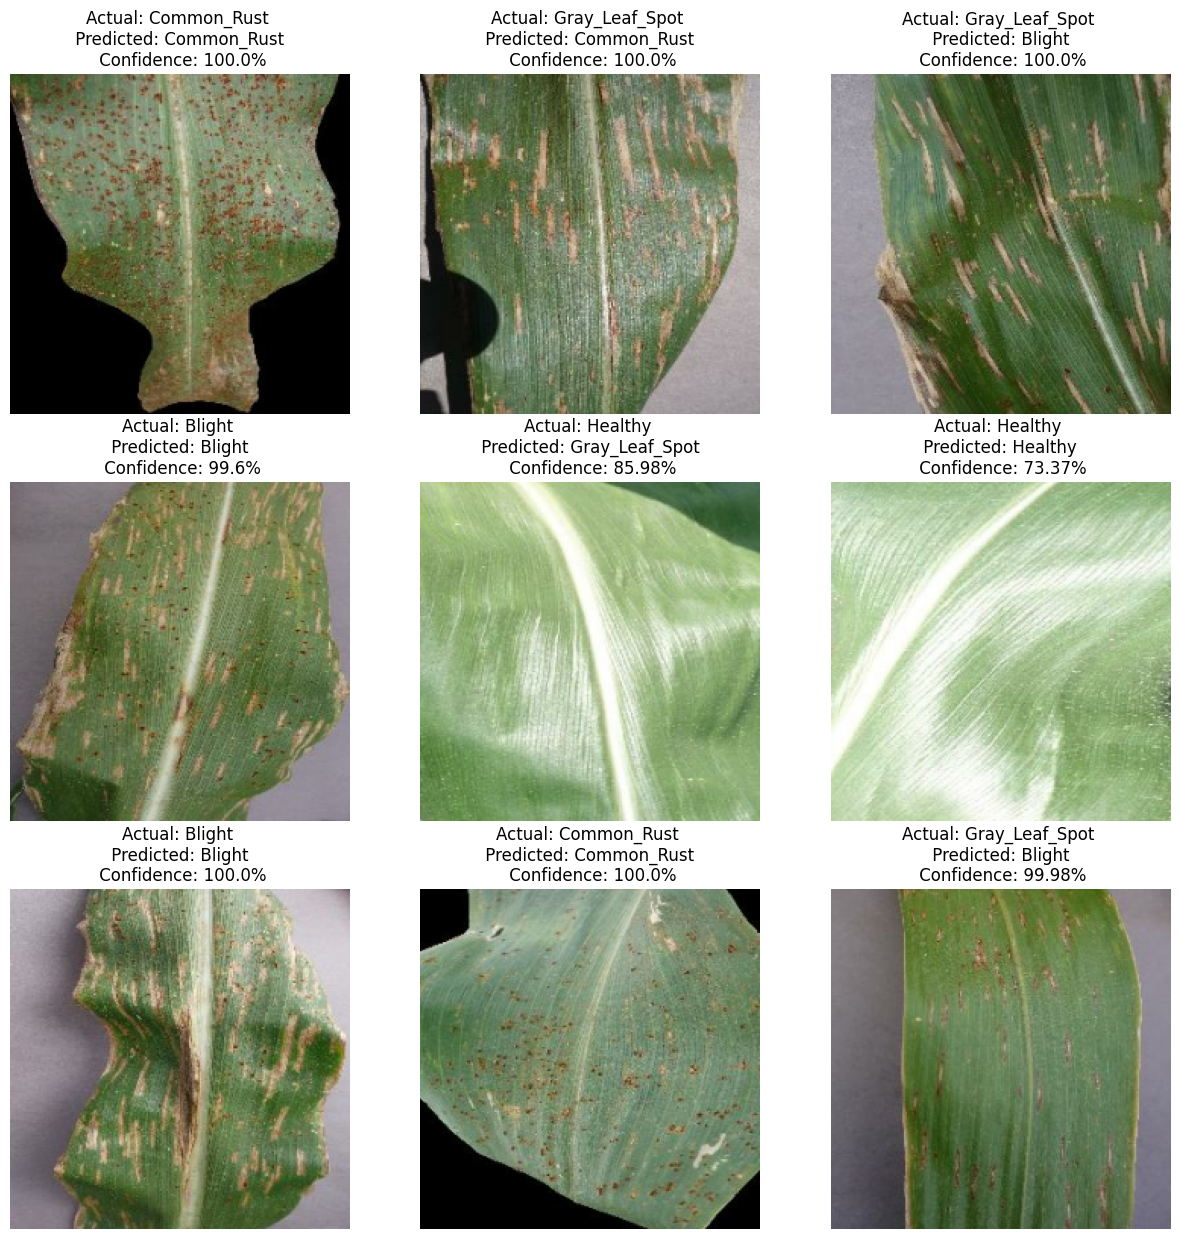

In [30]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}%")
        
        plt.axis("off")

In [31]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/3\assets


INFO:tensorflow:Assets written to: models/3\assets
